In [1]:
import sys
sys.path.insert(0, "C:\project\ML_PSU\PSU\pythonProject1\metrics")
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
from Evaluator import *
from utils import *
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import glob
import shutil
from tqdm.auto import tqdm
from utility import get_iou_yolo
IMAGE_SIZE = 512
PATH_DIR_DETECTED_CSV= r"C:\project\Computer_Vision\term_paper_2023\experiments\anti UAV\detection.csv"
PATH_DIR_DETECTED_2_CSV= r"C:\project\Computer_Vision\term_paper_2023\experiments\Anti UAV with small drone\detection.csv"
IOUThreshold = 0.5

In [2]:
def label_yolo_to_csv(path_labels):
    id_class = []
    id_image = []
    x = []
    y = []
    w = []
    h = []
    paths = glob.glob(os.path.join(path_labels,"*.txt"))
    for path in  paths :
        id_ = path.split('\\')[-1].split('.')[0]
        fh1 = open(path, "r")
        for line in fh1:
            line = line.replace("\n", "")
            if line.replace(' ', '') == '':
                continue
            splitLine = line.split(" ")
            id_class.append(splitLine[0])
            x.append(float(splitLine[1]))
            y.append(float(splitLine[2]))
            w.append(float(splitLine[3]))
            h.append(float(splitLine[4]))
            id_image.append(id_)

    df = pd.DataFrame({'id_image': id_image,
                       'id_class':id_class,
                        'xc': x,
                        'yc' : y,
                        'w': w,
                        'h' : h})
    return df


In [3]:
def getBoundingBoxesFromCSV(df_detected, df_ground_truth ,image_size=512):
    allBoundingBoxes = BoundingBoxes()
    for i, row in df_detected.iterrows():
         bb = BoundingBox(
                float(row["id_image"]),
                float(row["id_class"]),
                float(row["xc"]),
                float(row["yc"]),
                float(row["w"]),
                float(row["h"]),
                CoordinatesType.Relative,
                (IMAGE_SIZE, IMAGE_SIZE),
                BBType.Detected,
                float(row["conf"]),
                format=BBFormat.XYWH)
         allBoundingBoxes.addBoundingBox(bb)

    for i, row in df_ground_truth.iterrows():
         bb = BoundingBox(
                float(row["id_image"]),
                float(row["id_class"]),
                float(row["xc"]),
                float(row["yc"]),
                float(row["w"]),
                float(row["h"]),
                CoordinatesType.Relative,
                (IMAGE_SIZE, IMAGE_SIZE),
                BBType.GroundTruth,
                format=BBFormat.XYWH)
         allBoundingBoxes.addBoundingBox(bb)
    return allBoundingBoxes

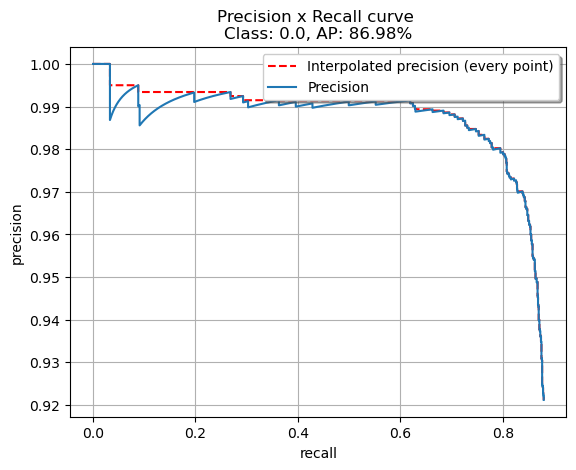

In [4]:
df_ground_truth = label_yolo_to_csv(r"C:\project\Computer_Vision\term_paper_2023\experiments\anti UAV\Anti_UAV_yolo\test\labels")
df_detected = pd.read_csv(PATH_DIR_DETECTED_CSV)
df_detected["id_class"] = 0
boundingboxes = getBoundingBoxesFromCSV(df_detected,df_ground_truth)

evaluator = Evaluator()

result = evaluator.PlotPrecisionRecallCurve(
    boundingboxes,  # Object containing all bounding boxes (ground truths and detections)
    IOUThreshold=IOUThreshold,  # IOU threshold
    method=MethodAveragePrecision.EveryPointInterpolation,  # As the official matlab code
    showAP=True,  # Show Average Precision in the title of the plot
    showInterpolatedPrecision=True)

In [5]:
detections = np.asarray(result[0]["detections"],dtype=object)
groundTruths = np.asarray(result[0]["groundTruths"],dtype=object)
TP = np.asarray(result[0]["TP"])
FP = np.asarray(result[0]["FP"])
FN = np.asarray(result[0]["FN"])
area_TP = []
area_FP = []
area_FN = []

for id, gt in enumerate(detections):
    x1 = gt[3][0]
    y1 = gt[3][1]
    x2 = gt[3][2]
    y2 = gt[3][3]
    area = (x2-x1)*(y2-y1)/IMAGE_SIZE/IMAGE_SIZE
    if FP[id] == 1:
        area_FP.append(area)

for id, gt in enumerate(groundTruths):
    x1 = gt[3][0]
    y1 = gt[3][1]
    x2 = gt[3][2]
    y2 = gt[3][3]
    area = (x2-x1)*(y2-y1)/IMAGE_SIZE/IMAGE_SIZE
    if FN[id] == 1:
        area_FN.append(area)

TP.sum() / (FN.sum()+TP.sum())

0.8797327394209354

In [6]:
df_area_FP = pd.DataFrame(area_FP)
df_area_FP.describe()

,0
count,169.000000
mean,0.001476
std,0.006032
min,0.000057
25%,0.000244
50%,0.000381
75%,0.000641
max,0.062485


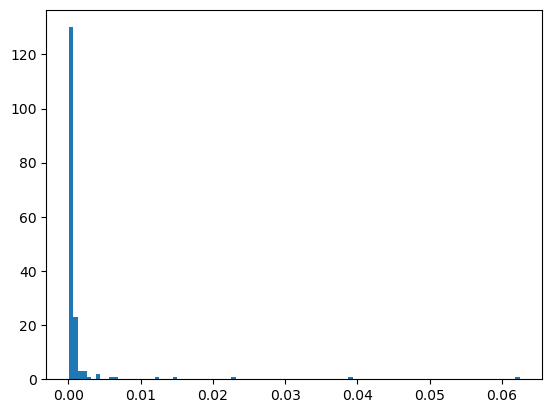

In [7]:
plt.hist(area_FP, bins=100)
plt.show()

In [8]:
df_area_FN = pd.DataFrame(area_FN)
df_area_FN.describe()

,0
count,270.000000
mean,0.006154
std,0.021169
min,0.000023
25%,0.000160
50%,0.000336
75%,0.000916
max,0.191406


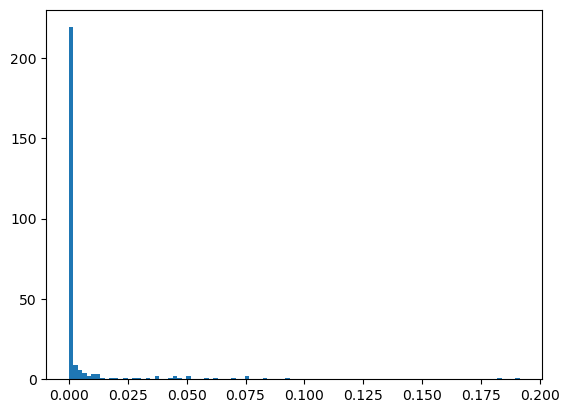

In [9]:

plt.hist(area_FN, bins=100)
plt.show()

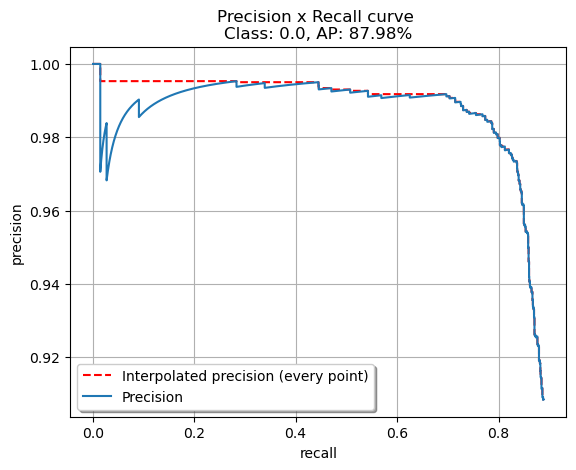

In [10]:
df_ground_truth = label_yolo_to_csv(r"C:\project\Computer_Vision\term_paper_2023\experiments\anti UAV\Anti_UAV_yolo\test\labels")
df_detected = pd.read_csv(PATH_DIR_DETECTED_2_CSV)
df_detected["id_class"] = 0
boundingboxes = getBoundingBoxesFromCSV(df_detected,df_ground_truth)

evaluator = Evaluator()

result = evaluator.PlotPrecisionRecallCurve(
    boundingboxes,  # Object containing all bounding boxes (ground truths and detections)
    IOUThreshold=IOUThreshold,  # IOU threshold
    method=MethodAveragePrecision.EveryPointInterpolation,  # As the official matlab code
    showAP=True,  # Show Average Precision in the title of the plot
    showInterpolatedPrecision=True)

In [11]:
detections = np.asarray(result[0]["detections"],dtype=object)
groundTruths = np.asarray(result[0]["groundTruths"],dtype=object)
TP = np.asarray(result[0]["TP"])
FP = np.asarray(result[0]["FP"])
FN = np.asarray(result[0]["FN"])
area_TP = []
area_FP = []
area_FN = []

for id, gt in enumerate(detections):
    x1 = gt[3][0]
    y1 = gt[3][1]
    x2 = gt[3][2]
    y2 = gt[3][3]
    area = (x2-x1)*(y2-y1)/IMAGE_SIZE/IMAGE_SIZE
    if FP[id] == 1:
        area_FP.append(area)

for id, gt in enumerate(groundTruths):
    x1 = gt[3][0]
    y1 = gt[3][1]
    x2 = gt[3][2]
    y2 = gt[3][3]
    area = (x2-x1)*(y2-y1)/IMAGE_SIZE/IMAGE_SIZE
    if FN[id] == 1:
        area_FN.append(area)

TP.sum() / (FN.sum()+TP.sum())

0.889086859688196

In [12]:
df_area_FP = pd.DataFrame(area_FP)
df_area_FP.describe()

,0
count,201.000000
mean,0.002317
std,0.013329
min,0.000092
25%,0.000275
50%,0.000397
75%,0.000629
max,0.174820


In [13]:
df_area_FN = pd.DataFrame(area_FN)
df_area_FN.describe()

,0
count,249.000000
mean,0.004614
std,0.019450
min,0.000023
25%,0.000160
50%,0.000343
75%,0.000843
max,0.191406


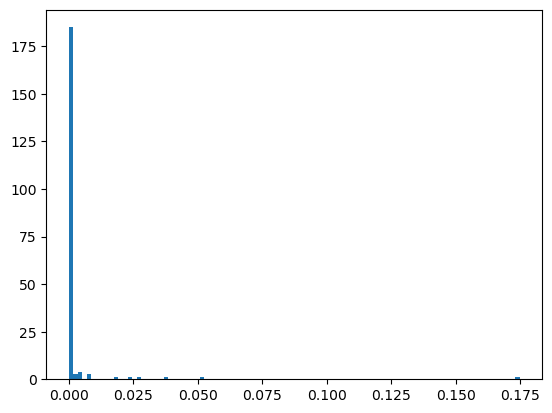

In [14]:
plt.hist(area_FP, bins=100)
plt.show()

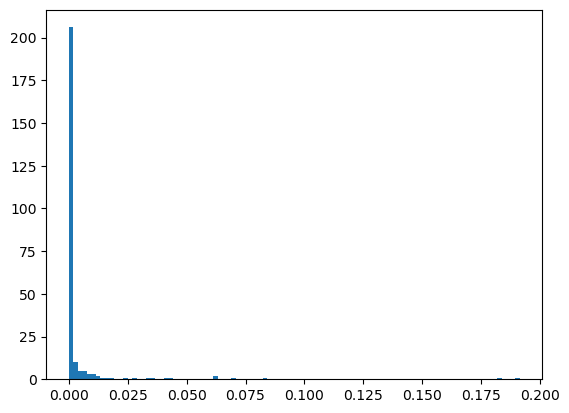

In [15]:
import matplotlib.pyplot as plt
plt.hist(area_FN, bins=100)
plt.show()